# Rugby Data Exploration

This notebook explores the structure of the rugby match data and validates the data pipeline.

In [1]:
import sys
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rugby_ranking.model.data import MatchDataset

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## Load Data

Point this to your Rugby-Data repository.

In [2]:
DATA_DIR = Path("../../Rugby-Data")  # Adjust path as needed

dataset = MatchDataset(DATA_DIR, fuzzy_match_names=False)
dataset.load_json_files()

Unknown format in ../../Rugby-Data/json/euro-challenge-2021-2022.json, skipping
Loaded 13952 matches from ../../Rugby-Data/json
Found 10118 unique players
Found 144 unique teams


In [3]:
# Convert to DataFrame
df = dataset.to_dataframe(played_only=True)
print(f"Shape: {df.shape}")
df.head()

Shape: (385342, 25)


,player_name,player_id,team,team_id,opponent,opponent_id,match_id,season,competition,date,is_home,position,minutes_played,started,was_substituted,tries,conversions,penalties,drop_goals,total_points,yellow_cards,red_cards,team_score,opponent_score,match_result
0,Thinus Delport,3417,Worcester Warriors,35,Bristol Bears,28,premiership_2006-2007_133,2006-2007,premiership,2006-09-02 00:00:00+00:00,True,7,80.0,True,False,0,0,0,0,0,0,0,11,41,loss
1,Tom Ryder,764,Saracens,25,Wasps,56,premiership_2006-2007_134,2006-2007,premiership,2006-09-02 00:00:00+00:00,True,17,0.0,False,False,0,0,0,0,0,0,0,19,21,loss
2,Rodd Penney,859,Saracens,25,Wasps,56,premiership_2006-2007_134,2006-2007,premiership,2006-09-02 00:00:00+00:00,True,16,18.0,False,False,0,0,0,0,0,0,0,19,21,loss
3,Richard Haughton,4226,Saracens,25,Wasps,56,premiership_2006-2007_134,2006-2007,premiership,2006-09-02 00:00:00+00:00,True,8,62.0,True,True,0,0,0,0,0,0,0,19,21,loss
4,Dan Scarbrough,3306,Saracens,25,Wasps,56,premiership_2006-2007_134,2006-2007,premiership,2006-09-02 00:00:00+00:00,True,7,80.0,True,False,0,0,0,0,0,0,0,19,21,loss


## Data Overview

In [4]:
print("Competitions:")
print(df['competition'].value_counts())
print("\nSeasons:")
print(df['season'].value_counts().sort_index())

Competitions:
competition
celtic            108990
premiership       107822
euro-champions     56560
euro-challenge     48563
pro-d2             33256
top14              30151
Name: count, dtype: int64

Seasons:
season
2006-2007     6372
2007-2008     8801
2008-2009    13490
2009-2010    16137
2010-2011    17735
2011-2012    17902
2012-2013    20498
2013-2014    16268
2014-2015    16324
2015-2016    18241
2016-2017    18669
2017-2018    19379
2018-2019    19176
2019-2020    18555
2020-2021    21355
2021-2022    15232
2022-2023    35142
2023-2024    33810
2024-2025    33902
2025-2026    18354
Name: count, dtype: int64


In [5]:
print(f"Unique players: {df['player_name'].nunique()}")
print(f"Unique teams: {df['team'].nunique()}")
print(f"Unique matches: {df['match_id'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Unique players: 10117
Unique teams: 102
Unique matches: 8668
Date range: 2006-09-02 00:00:00+00:00 to 2026-01-14 22:39:43.340666+00:00


## Scoring Distributions

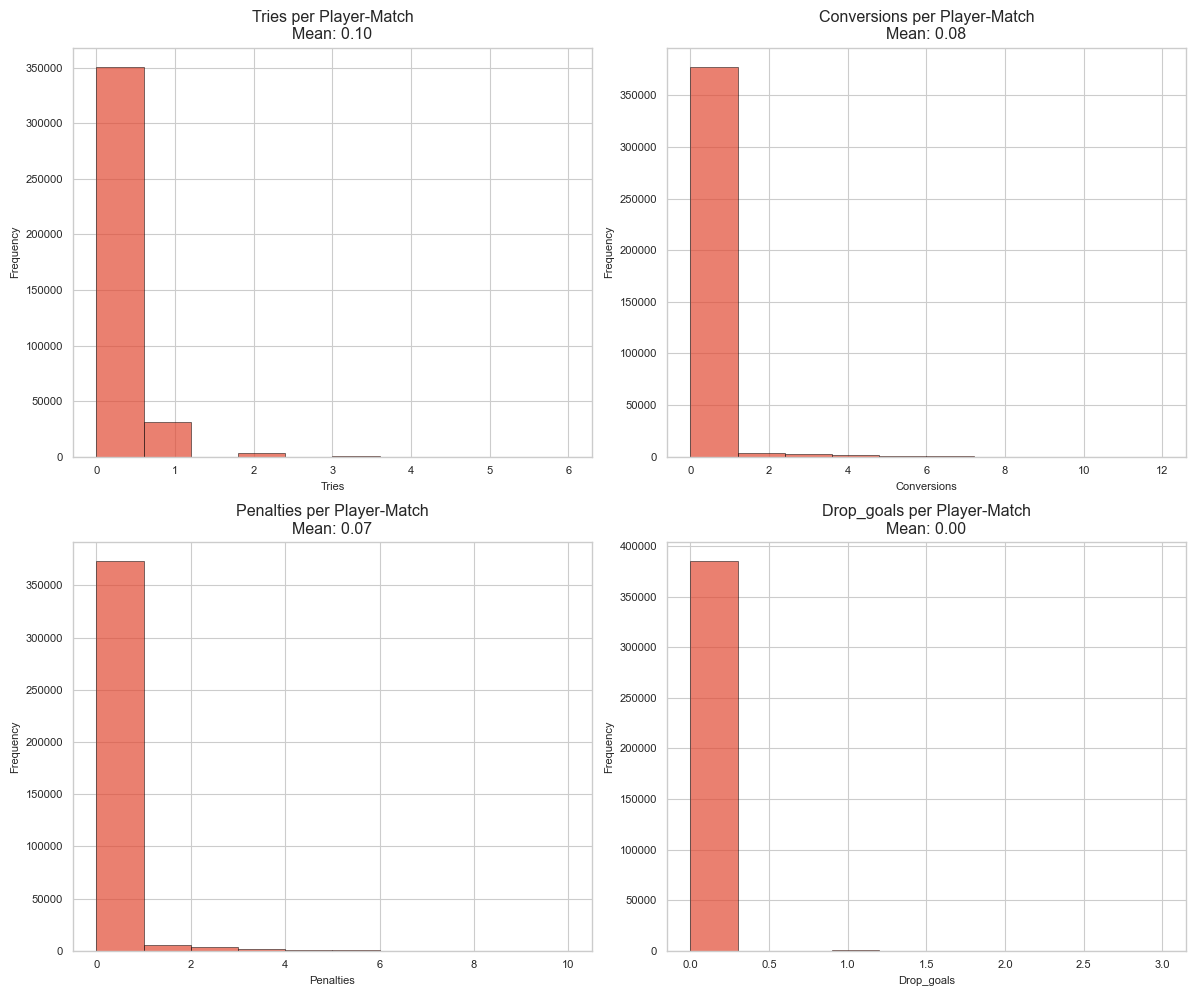

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, score_type in zip(axes.flat, ['tries', 'conversions', 'penalties', 'drop_goals']):
    data = df[score_type]
    ax.hist(data,  edgecolor='black', alpha=0.7)
    ax.set_xlabel(score_type.capitalize())
    ax.set_ylabel('Frequency')
    ax.set_title(f'{score_type.capitalize()} per Player-Match\nMean: {data.mean():.2f}')

plt.tight_layout()
plt.show()

## Position Analysis

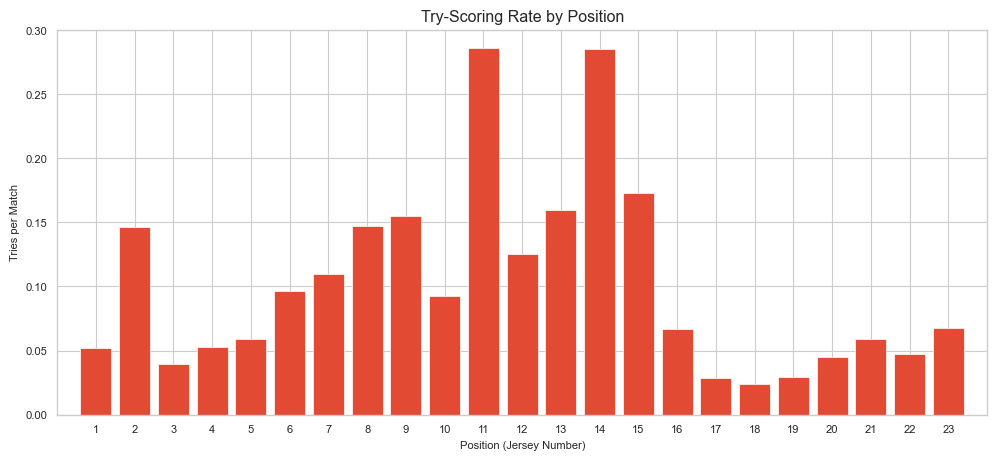

In [7]:
# Tries by position
position_tries = df.groupby('position')['tries'].agg(['sum', 'mean', 'count'])
position_tries.columns = ['total_tries', 'tries_per_match', 'appearances']

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(position_tries.index, position_tries['tries_per_match'])
ax.set_xlabel('Position (Jersey Number)')
ax.set_ylabel('Tries per Match')
ax.set_title('Try-Scoring Rate by Position')
ax.set_xticks(range(1, 24))
ax.set_xlim([0,24])
plt.show()

# Position labels for reference
positions = {
    1: 'Loosehead Prop', 2: 'Hooker', 3: 'Tighthead Prop',
    4: 'Lock', 5: 'Lock', 6: 'Blindside Flanker',
    7: 'Openside Flanker', 8: 'Number 8',
    9: 'Scrum-half', 10: 'Fly-half', 11: 'Left Wing',
    12: 'Inside Centre', 13: 'Outside Centre', 14: 'Right Wing', 15: 'Fullback',
    16: 'Sub', 17: 'Sub', 18: 'Sub', 19: 'Sub', 20: 'Sub', 21: 'Sub', 22: 'Sub', 23: 'Sub'
}

## Player Mobility

How often do players change teams?

In [8]:
player_teams = dataset.get_player_teams()

# Count teams per player
teams_per_player = player_teams.groupby('player_name')['team'].nunique()
print("Teams per player distribution:")
print(teams_per_player.value_counts().sort_index())

# Players who played for multiple teams
mobile_players = teams_per_player[teams_per_player > 1]
print(f"\n{len(mobile_players)} players played for multiple teams ({100*len(mobile_players)/len(teams_per_player):.1f}%)")

Teams per player distribution:
team
1     6442
2     2263
3      950
4      334
5      100
6       18
7        7
8        2
19       1
Name: count, dtype: int64

3675 players played for multiple teams (36.3%)


In [9]:
teams_per_player[teams_per_player > 10]

player_name
Simon Darcy    19
Name: team, dtype: int64

In [10]:
# Example: players who changed teams
if len(mobile_players) > 0:
    example_player = teams_per_player[teams_per_player > 10].index[0] # mobile_players.index[5]
    print(f"\nCareer of {example_player}:")
    display(player_teams[player_teams['player_name'] == example_player])


Career of Simon Darcy:


,player_name,team,season,matches,minutes_played,tries,total_points
34348,Simon Darcy,Bath Rugby,2006-2007,1,80.0,0,0
34349,Simon Darcy,Bayonne,2006-2007,1,0.0,0,0
34350,Simon Darcy,Benetton Rugby,2006-2007,1,80.0,0,0
34351,Simon Darcy,Borders,2006-2007,1,80.0,0,0
34352,Simon Darcy,Bourgoin,2006-2007,2,160.0,0,0
34353,Simon Darcy,Bristol Bears,2006-2007,2,80.0,0,0
34354,Simon Darcy,Clermont,2006-2007,1,80.0,0,0
34355,Simon Darcy,Connacht Rugby,2006-2007,1,0.0,0,0
34356,Simon Darcy,Crociati,2006-2007,1,0.0,0,0
34357,Simon Darcy,Dragons RFC,2006-2007,1,0.0,0,0


## Minutes Played Distribution

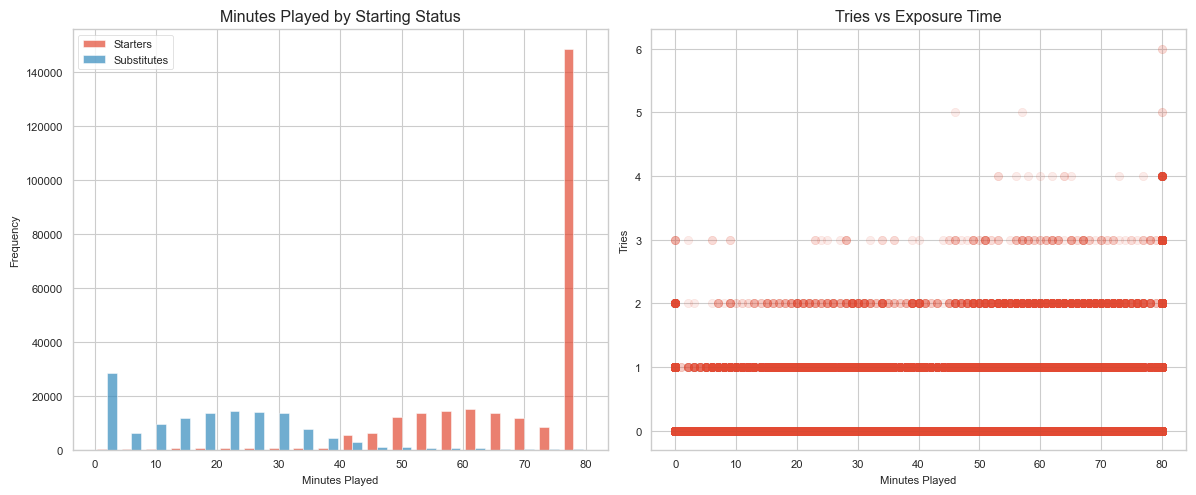

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Starters vs subs
axes[0].hist([df[df['started']]['minutes_played'], df[~df['started']]['minutes_played']], 
             bins=20, label=['Starters', 'Substitutes'], alpha=0.7)
axes[0].set_xlabel('Minutes Played')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Minutes Played by Starting Status')
axes[0].legend()

# Exposure vs tries
axes[1].scatter(df['minutes_played'], df['tries'], alpha=0.1)
axes[1].set_xlabel('Minutes Played')
axes[1].set_ylabel('Tries')
axes[1].set_title('Tries vs Exposure Time')

plt.tight_layout()
plt.show()

## Disciplinary Analysis

Yellow cards: 6865
Red cards: 341

Matches with cards: 4304 (yellow)
                     313 (red)


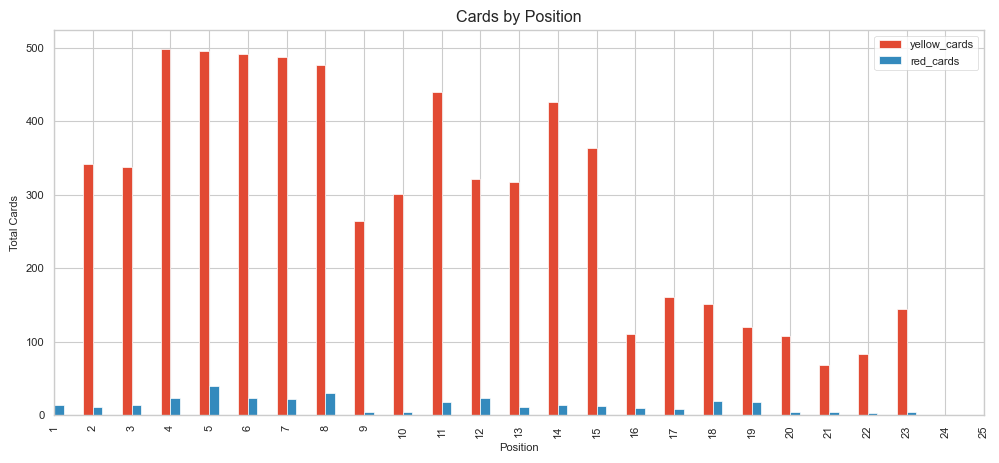

In [12]:
print(f"Yellow cards: {df['yellow_cards'].sum()}")
print(f"Red cards: {df['red_cards'].sum()}")
print(f"\nMatches with cards: {df[df['yellow_cards'] > 0]['match_id'].nunique()} (yellow)")
print(f"                     {df[df['red_cards'] > 0]['match_id'].nunique()} (red)")

# Cards by position
cards_by_pos = df.groupby('position')[['yellow_cards', 'red_cards']].sum()
cards_by_pos.plot(kind='bar', figsize=(12, 5))
plt.title('Cards by Position')
plt.xlabel('Position')
plt.ylabel('Total Cards')
plt.xlim([0,24])
plt.show()

## Unplayed Matches (for prediction)

In [13]:
unplayed = dataset.get_unplayed_matches()
print(f"Unplayed matches: {len(unplayed)}")

if unplayed:
    print("\nUpcoming fixtures:")
    for match in unplayed[:10]:
        print(f"  {match.home_team} vs {match.away_team} ({match.competition})")

Unplayed matches: 187

Upcoming fixtures:
  Munster Rugby vs Dragons RFC (celtic)
  Edinburgh Rugby vs Vodacom Bulls (celtic)
  Ospreys vs Emirates Lions (celtic)
  Scarlets vs Ulster Rugby (celtic)
  DHL Stormers vs Hollywoodbets Sharks (celtic)
  Connacht Rugby vs Leinster Rugby (celtic)
  Cardiff Rugby vs Benetton Rugby (celtic)
  Zebre Parma vs Glasgow Warriors (celtic)
  Glasgow Warriors vs Munster Rugby (celtic)
  Benetton Rugby vs Scarlets (celtic)


## Summary Statistics for Modelling

In [14]:
print("Key statistics for model specification:")
print(f"  - Total observations: {len(df):,}")
print(f"  - Players: {df['player_name'].nunique():,}")
print(f"  - Teams: {df['team'].nunique()}")
print(f"  - Seasons: {df['season'].nunique()}")
print(f"  - Team-seasons: {df.groupby(['team', 'season']).ngroups}")
print(f"  - Mean tries per player-match: {df['tries'].mean():.3f}")
print(f"  - Mean penalties per player-match: {df['penalties'].mean():.3f}")
print(f"  - Mean minutes played: {df['minutes_played'].mean():.1f}")
print(f"  - Home win rate: {(df.groupby('match_id').first()['match_result'] == 'win').mean():.1%}")

Key statistics for model specification:
  - Total observations: 385,342
  - Players: 10,117
  - Teams: 102
  - Seasons: 20
  - Team-seasons: 909
  - Mean tries per player-match: 0.102
  - Mean penalties per player-match: 0.066
  - Mean minutes played: 52.7
  - Home win rate: 48.1%
